In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c store-sales-time-series-forecasting
!unzip /content/store-sales-time-series-forecasting.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/store-sales-time-series-forecasting.zip
replace holidays_events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: holidays_events.csv     
replace oil.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Y
  inflating: oil.csv                 
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_csv('/content/train.csv', parse_dates = ['date'], index_col = 'date')

df_hol = pd.read_csv('/content/holidays_events.csv', index_col = 'date', parse_dates = ['date'])
df_hol.rename(columns = {'type': 'holiday'}, inplace = True)
df_hol.drop_duplicates(inplace = True)

df_oil = pd.read_csv('/content/oil.csv', index_col = 'date', parse_dates = ['date'])
df_oil.rename(columns = {'dcoilwtico': 'oil_price'}, inplace = True)
df_oil.drop_duplicates(inplace = True)
df_oil.bfill(inplace = True)


In [6]:
df = df.groupby(df.index).agg(
    {
        'sales': 'sum',
        'store_nbr': 'sum',
        'onpromotion': 'sum',
    }
)

df.shape

(1684, 3)

In [7]:
df = df.merge(df_oil, left_index = True, right_index = True, how = 'left').bfill()

In [8]:
df = df.merge(df_hol['holiday'], left_index = True, right_index = True, how = 'left')

In [9]:
df['holiday'] = (df.holiday.isna() == False).astype(int)
df.head()

,sales,store_nbr,onpromotion,oil_price,holiday
date,,,,,
2013-01-01,2511.618999,49005,0,93.14,1
2013-01-02,496092.417944,49005,0,93.14,0
2013-01-03,361461.231124,49005,0,92.97,0
2013-01-04,354459.677093,49005,0,93.12,0
2013-01-05,477350.121229,49005,0,93.20,1


In [10]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

In [ ]:
def feature_engineering(dataframe):
    df = dataframe.copy()


    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear

    df['is_month_end'] = (df.index.is_month_end).astype(int)
    df['is_month_start'] = (df.index.is_month_start).astype(int)
    df['is_quarter_end'] = (df.index.is_quarter_end).astype(int)
    df['is_quarter_start'] = (df.index.is_quarter_start).astype(int)
    df['is_year_end'] = (df.index.is_year_end).astype(int)
    df['is_year_start'] = (df.index.is_year_start).astype(int)


    df['day_sin'] = np.sin(df.index.day * 2 * np.pi / 30)
    df['day_cos'] = np.cos(df.index.day * 2 * np.pi / 30)
    df['day_of_week_sin'] = np.sin(df.index.dayofweek * 2 * np.pi / 7)
    df['day_of_week_cos'] = np.cos(df.index.dayofweek * 2 * np.pi / 7)
    df['day_of_year_sin'] = np.sin(df.index.dayofyear * 2 * np.pi / 365)
    df['day_of_year_cos'] = np.cos(df.index.dayofyear * 2 * np.pi / 356)

    # Relative position in sequence (helps LSTM understand context)
    df['days_from_start'] = (df.index - df.index[0]).days
    # df['recent_trend'] = df['sales'].diff(1)
    # df['combined_trend'] = df['sales'].diff(1).diff(7)


    fourier = CalendarFourier(freq = "ME", order = 10)

    dp = DeterministicProcess(
        index = df.index,
        constant = True,
        order = 2,
        seasonal = False,
        additional_terms = [fourier],
        drop = True
    )


    df = pd.concat([df, dp.in_sample()], axis = 1)
    df.dropna(inplace = True)

    return df

In [12]:
# Here is one way, but I will do it using pytroch Dataset class
def create_sequences_for_rnn(dataframe, sequence_length=30, target_col='sales'):
    df = dataframe.copy()

    features = df.drop(target_col, axis=1)
    targets = df[target_col]

    X, y = [], []

    for i in tqdm(range(len(df) - sequence_length), desc = "Preprocessing sequences"):
        seq = features.iloc[i: i + sequence_length].values
        target = targets.iloc[i + sequence_length]
        X.append(seq)
        y.append(target)

    # X.shape --> (len(df), sequence, num_feature)
    # y.shape --> (len(df))

    return np.array(X), np.array(y)

In [13]:
stats = feature_engineering(df)
stats.head(2)

,sales,store_nbr,onpromotion,oil_price,holiday,year,month,day,day_of_week,day_of_year,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,sin_day,cos_day,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,days_from_start,const,trend,trend_squared,"sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)","sin(5,freq=ME)","cos(5,freq=ME)","sin(6,freq=ME)","cos(6,freq=ME)","sin(7,freq=ME)","cos(7,freq=ME)","sin(8,freq=ME)","cos(8,freq=ME)","sin(9,freq=ME)","cos(9,freq=ME)","sin(10,freq=ME)","cos(10,freq=ME)"
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2511.618999,49005,0,93.14,1,2013,1,1,1,1,0,1,0,1,0,1,0.207912,0.978148,0.781831,0.623490,0.017213,0.999844,0,1.0,1.0,1.0,0.000000,1.00000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2013-01-02,496092.417944,49005,0,93.14,0,2013,1,2,2,2,0,0,0,0,0,0,0.406737,0.913545,0.974928,-0.222521,0.034422,0.999377,1,1.0,2.0,4.0,0.201299,0.97953,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,0.848644,0.528964,0.937752,0.347305,0.988468,0.151428,0.998717,-0.050649,0.968077,-0.250653,0.897805,-0.440394


In [14]:
X, y = create_sequences_for_rnn(stats, sequence_length = 3, target_col = 'sales')

X.shape, y.shape

Preprocessing sequences:   0%|          | 0/1681 [00:00<?, ?it/s]

((1681, 3, 45), (1681,))

In [15]:
# pytroch dataset
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(
            self, dataframe, seq_length, target_col, num_target_steps = 1,
            feature_scaler = None, target_scaler = None
    ):

        self.df = dataframe
        self.seq_length = seq_length
        # self.target_col = target_col
        self.num_target_steps = num_target_steps

        features_cols = [col for col in self.df.columns if col != target_col]

        self.feature_scaler = feature_scaler if feature_scaler else StandardScaler()
        self.target_scaler = target_scaler if target_scaler else StandardScaler()

        # for val and test we use training scalers
        if feature_scaler and target_scaler:
            print('Preparing data for evaluation or test ...')
            self.features_array = self.feature_scaler.transform(self.df[features_cols].values)
            self.target_array = self.target_scaler.transform(self.df[target_col].values.reshape(-1, 1))
        # for trainning
        else:
            print('Preparing data for training ...')
            self.features_array = self.feature_scaler.fit_transform(self.df[features_cols].values)
            self.target_array = self.target_scaler.fit_transform(self.df[target_col].values.reshape(-1, 1))


    def get_scalers(self):
        return self.feature_scaler, self.target_scaler

    def inverse_transform(self, scaled_features, scaled_target):
        revert_feats = self.feature_scaler.inverse_transform(scaled_features)
        revert_target = self.target_scaler.inverse_transform(scaled_target.reshape(-1, 1)).flatten()
        return revert_feats, revert_target

    def __len__(self):
        return (len(self.df) - self.seq_length - self.num_target_steps + 1)

    def __getitem__(self, idx):
        target_start = idx + self.seq_length
        target_end = target_start + self.num_target_steps

        if target_end > len(self.df):
            raise IndexError("Index out of range")

        features = self.features_array[idx: target_start]
        target = self.target_array[target_start: target_end]

        # after applyin DataLoader
        # X.shape --> (batch_size, sequence, num_feature)
        # y.shape --> (batch_size)
        features = torch.FloatTensor(features)
        target = torch.FloatTensor(target).reshape(-1)

        return features, target

In [17]:
# Check the code

datset = TimeSeriesDataset(stats, seq_length = 30, target_col = 'sales', num_target_steps = 1)
loader = DataLoader(datset, batch_size = 32)
a, b = next(iter(loader))
a.shape, b.shape

Preparing data for training ...


(torch.Size([32, 30, 45]), torch.Size([32, 1]))

## RNNs and their cells

[Understand LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### why RNNs:
- unlike traditional models RNNs maintain a memory of previous states. This allows them to capture temporal patterns and long-range dependencies
- can process sequences of any length,
- temporal Feature Learning: Instead of manually engineering lag features (like `sales_lag_1`, `sales_lag_2`, etc.), RNNs automatically learn which past time steps are most relevant for prediction.
- it has stateful memory, since hidden state acts as a compressed representation(Handle seasonality and trends naturally).

> LSTM and GRU solve the vanishing gradient problem through gating mechanisms that create constant error carousels

> The hidden state is the core mechanism that enables temporal dependencies by carrying information across time steps.

> Temporal dependencies are relationships between data points at different time steps

<br>

$$
h_t = f(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

```py
# Simple RNN hidden state update
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.W_xh = nn.Linear(input_size, hidden_size)  # Input to hidden
        self.W_hh = nn.Linear(hidden_size, hidden_size) # Hidden to hidden
    
    def forward(self, x, h_prev):
        # h_t = tanh(W_xh * x_t + W_hh * h_{t-1})
        h_new = torch.tanh(self.W_xh(x) + self.W_hh(h_prev))
        return h_new

# Time:    t=0      t=1      t=2      t=3
#         ┌───┐    ┌───┐    ┌───┐    ┌───┐
# Input:  │ x₀ │ → │ x₁ │ → │ x₂ │ → │ x₃ │
#         └───┘    └───┘    └───┘    └───┘
#           ↓        ↓        ↓        ↓
#         ┌───┐    ┌───┐    ┌───┐    ┌───┐
# Hidden: │ h₀ │ → │ h₁ │ → │ h₂ │ → │ h₃ │
#         └───┘    └───┘    └───┘    └───┘
```

$$
\begin{split}
    f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f), \\
    i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i), \\
    C_t &= f_t \cdot C_{t-1} + i_t \cdot \tilde{C_t}
\end{split}
$$

```py
class LSTMCell(nn.Module):
    def forward(self, x, h_prev, c_prev):
        # Input gate, Forget gate, Output gate, Candidate
        i = torch.sigmoid(self.W_xi(x) + self.W_hi(h_prev))
        f = torch.sigmoid(self.W_xf(x) + self.W_hf(h_prev))  
        o = torch.sigmoid(self.W_xo(x) + self.W_ho(h_prev))
        g = torch.tanh(self.W_xg(x) + self.W_hg(h_prev))
        
        # Cell state update (LONG-TERM MEMORY)
        c_new = f * c_prev + i * g
        
        # Hidden state update (SHORT-TERM OUTPUT)
        h_new = o * torch.tanh(c_new)
        
        return h_new, c_new

# Time:    t=0        t=1        t=2        t=3
#         ┌─────┐    ┌─────┐    ┌─────┐    ┌─────┐
# Cell:   │ c₀ │ ──→ │ c₁ │ ──→ │ c₂ │ ──→ │ c₃ │  (Long-term memory)
#         └─────┘    └─────┘    └─────┘    └─────┘
#           ↓          ↓          ↓          ↓
#         ┌─────┐    ┌─────┐    ┌─────┐    ┌─────┐
# Hidden: │ h₀ │ ──→ │ h₁ │ ──→ │ h₂ │ ──→ │ h₃ │  (Short-term output)
#         └─────┘    └─────┘    └─────┘    └─────┘
```

```py
class GRUCell(nn.Module):
    def forward(self, x, h_prev):
        # Update gate: how much to update hidden state
        z = torch.sigmoid(self.W_xz(x) + self.W_hz(h_prev))
        
        # Reset gate: how much to forget previous hidden state  
        r = torch.sigmoid(self.W_xr(x) + self.W_hr(h_prev))
        
        # Candidate activation
        h_candidate = torch.tanh(self.W_xh(x) + self.W_hh(r * h_prev))
        
        # Final hidden state: interpolation between old and new
        h_new = (1 - z) * h_prev + z * h_candidate
        
        return h_new

```

<br>

### **Handling Vanishing Gradients in PyTorch**

```py
# Backward pass
optimizer.zero_grad()
loss.backward() # Computes gradients (∂loss/∂parameters)

# Gradient clipping
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
# max_norm = 1.0,  # Common values: 0.5, 1.0, 5.0
# norm_type = 2    # L2 norm

# Update weights
optimizer.step()
```

[PyTorch Time Series Example (Sequence Data)](https://docs.pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)

### Sequence-to-One

- Classification tasks (sentiment analysis, sequence classification)
- Final value prediction (tomorrow's stock price)
- Anomaly detection in sequence

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class LSTM(nn.Module):
    def __init__(
            self, input_size, output_size, hidden_size = 64, num_layers = 2, bidirectional = False
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_size,        # Number of features
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout = 0.2,                  # num_layers should be greater than 1
            bidirectional = bidirectional
        )

        # hidden_size = hidden_size * 2 if bidirectional else hidden_size

        self.norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        # x.shape: (batch_size, sequence_length, input_size)

        # LSTM returns: output, (hidden_state, cell_state)
        # out.shape: (batch_size, sequence_length, hidden_size)
        # hidden and cell.shape: (num_layers, batch_size, hidden_size)
        out, (hidden, cell) = self.lstm(x)

        # Use only the last hidden state for sequence-to-one
        out = self.norm(hidden[-1]) # shape: (batch_size, hidden_size)

        return self.fc((out))

In [ ]:
# class AttentionLSTM(nn.Module):
#     def __init__(self, input_size, output_size, hidden_size=64, num_layers=2):
#         super().__init__()
#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=0.2
#         )
        
#         self.attention = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size // 2),
#             nn.Tanh(),
#             nn.Linear(hidden_size // 2, 1)
#         )
        
#         self.fc = nn.Linear(hidden_size, output_size)
        
#     def forward(self, x):
#         # x.shape: (batch_size, sequence_length, input_size)
        
#         lstm_out, (hidden, cell) = self.lstm(x)  # (batch_size, seq_len, hidden_size)
        
#         # Apply attention over all timesteps
#         attention_weights = F.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
        
#         # Weighted sum of all hidden states
#         context_vector = torch.sum(attention_weights * lstm_out, dim=1)  # (batch_size, hidden_size)
        
#         return self.fc(context_vector)

In [34]:
from sklearn.model_selection import train_test_split
import random

# Prepare data
BS = 32
stats = feature_engineering(df)

train_idx, test_idx = train_test_split(stats.index, test_size = 0.2, shuffle = False)
val_idx, test_idx = train_test_split(test_idx, test_size = 0.5, shuffle = False)

train_stats = stats.loc[train_idx]
val_stats = stats.loc[val_idx]
test_stats = stats.loc[test_idx]

train_dataset = TimeSeriesDataset(
    train_stats,
    seq_length = 30,
    target_col = 'sales',
    num_target_steps = 1,
)

feature_scaler, target_scaler = train_dataset.get_scalers()


val_dataset = TimeSeriesDataset(
    val_stats,
    seq_length = 30,
    target_col = 'sales',
    num_target_steps = 1,
    feature_scaler = feature_scaler,
    target_scaler = target_scaler,
)

test_dataset = TimeSeriesDataset(
    test_stats,
    seq_length = 30,
    target_col = 'sales',
    num_target_steps = 1,
    feature_scaler = feature_scaler,
    target_scaler = target_scaler,
)


train_loader = DataLoader(train_dataset, batch_size = BS , drop_last = True, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = BS , drop_last = True, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BS , drop_last = True, shuffle = False)

Preparing data for training ...
Preparing data for evaluation or test ...
Preparing data for evaluation or test ...


In [35]:
feature, target = train_dataset[0]
feature.shape, target.shape

(torch.Size([30, 45]), torch.Size([1]))

In [ ]:
def calculate_metrics(predictions, targets):
    """Calculate all important metrics"""
    pred_np = predictions.cpu().detach().numpy()
    target_np = targets.cpu().detach().numpy()

    metrics = {
        'mse': [mean_squared_error(target_np, pred_np)],
        'mae': [mean_absolute_error(target_np, pred_np)],
        'rmse': [np.sqrt(mean_squared_error(target_np, pred_np))],
        'r2': [r2_score(target_np, pred_np)],
        'mape': [np.mean(np.abs((target_np - pred_np) / target_np)) * 100]
    }
    return metrics

In [43]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

model = LSTM(
    hidden_size = 16, input_size = feature.shape[-1], output_size = target.shape[-1]
)
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

In [ ]:
# Training loop

epoch = 25
train_losses = []
vall_losses = []

train_metrics = {}
val_metrics = {}

outer_pbar = tqdm(range(epoch), desc = 'Epoch')
for epoch in outer_pbar:
    inner_pbar = tqdm(train_loader, desc = 'Batch', leave = False)
    
    model.train()
    train_loss = 0
    train_met = {}
    for batch_x, batch_y in inner_pbar:

        optimizer.zero_grad()
        predictions = model(batch_x)  # (32, 1)
        loss = criterion(predictions, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        metrics = calculate_metrics(predictions, batch_y)

        for k, v in metrics.items():
            train_met[k] = train_met.get(k, 0) + v[0]


    for k, v in train_met.items():
        train_metrics[k] = train_metrics.get(k, []) + [v / len(train_loader)]


    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_met = {}
        for batch_x, batch_y in val_loader:
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()
            metrics = calculate_metrics(predictions, batch_y)
            for k, v in metrics.items():
                val_met[k] = val_met.get(k, 0) + v[0]

    for k, v in val_met.items():
        val_metrics[k] = val_metrics.get(k, []) + [v / len(val_loader)]


    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    vall_losses.append(val_loss)

    outer_pbar.set_postfix({'Train Loss': train_loss, 'Val Loss': val_loss})

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

Batch:   0%|          | 0/41 [00:00<?, ?it/s]

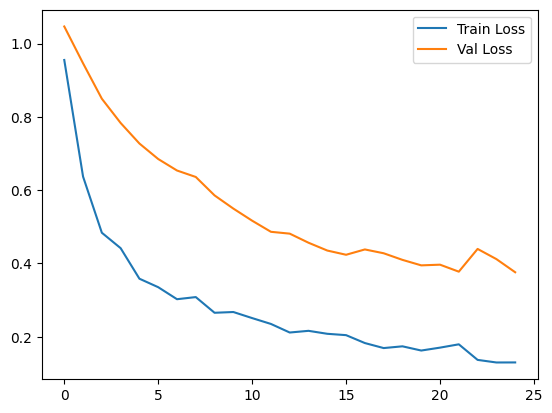

In [45]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(vall_losses, label = 'Val Loss')
plt.legend()
plt.show()

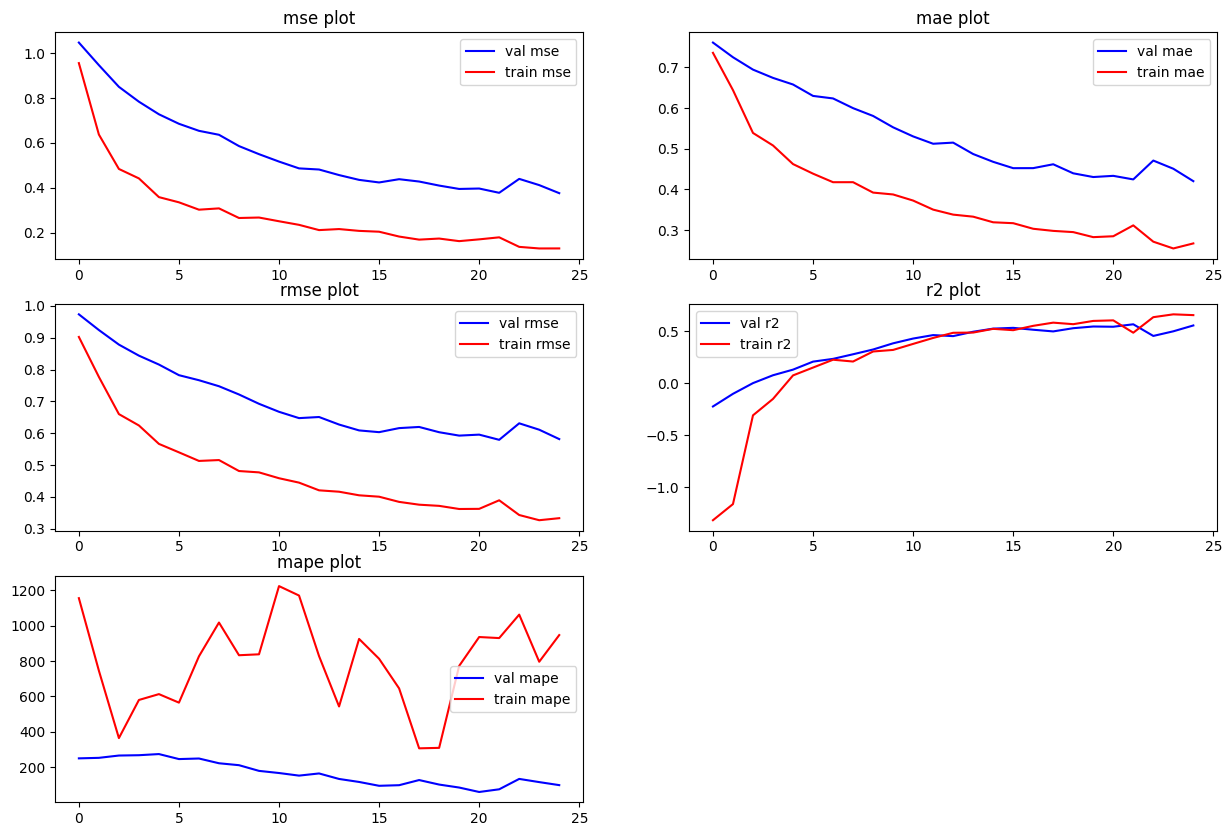

In [49]:
plt.figure(figsize=(15, 10))
for i, k in enumerate(val_metrics.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(val_metrics[k], label = f'val {k}', color = 'b')
    plt.plot(train_metrics[k], label = f'train {k}', color = 'r')
    plt.title(f"{k} plot")
    plt.legend()

plt.show()

In [47]:
truth = []
predictions = []
model.eval()
with torch.no_grad():
    val_loss = 0
    for batch_x, batch_y in test_loader:
        predictions.extend(model(batch_x).squeeze().squeeze().cpu().numpy())
        truth.extend(batch_y.squeeze().cpu().numpy())

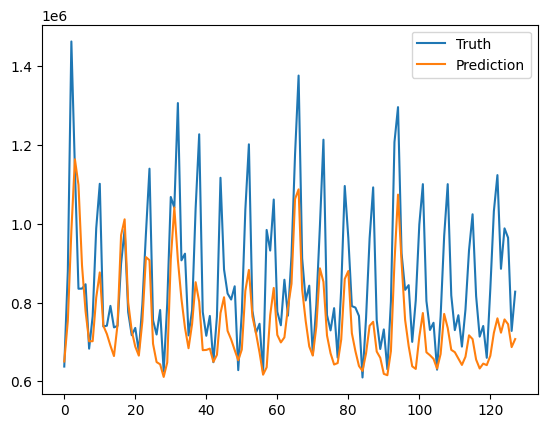

In [48]:
truth = train_dataset.inverse_transform_target(torch.tensor(truth))
predictions = train_dataset.inverse_transform_target(torch.tensor(predictions))

plt.plot(truth, label = 'Truth')
plt.plot(predictions, label = 'Prediction')
plt.legend()
plt.show()

### Sequence-to-Sequence

- Time series forecasting (predict multiple future steps)
- Machine translation
- Video frame prediction
- Music generation

```py
class LSTMSequenceToSequence(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        # same as befor
    
    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)  
        # lstm_out shape: (batch_size, sequence_length, hidden_size)
        
        # Apply linear layer to each time step
        outputs = self.fc(lstm_out)  # Shape: (batch_size, sequence_length, output_size)
        return outputs

```
<br>

Training:

```py
# For multi-step forecasting (e.g., predict next 7 days)
model = LSTMSequenceToSequence(input_size=5, hidden_size=64, num_layers=2, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    for batch_x, batch_y in dataloader:
        # batch_x: (32, 30, 5) - 30 days of features
        # batch_y: (32, 7, 1) - next 7 days of targets
        
        optimizer.zero_grad()
        predictions = model(batch_x)  # (32, 30, 1) - predictions for all 30 steps
        
        # Compare only the last 7 predictions with targets
        last_predictions = predictions[:, -7:, :]  # (32, 7, 1)
        loss = criterion(last_predictions, batch_y)
        loss.backward()
        optimizer.step()
```

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim


class LSTMseq2seq(nn.Module):
    def __init__(
            self, input_size, output_size, hidden_size = 64, num_layers = 2, bidirectional = False
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
            dropout=0.2,
            bidirectional = bidirectional
        )

        # hidden_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        # x.shape: (batch_size, sequence_length, input_size)

        # LSTM returns: output, (hidden_state, cell_state)
        # out.shape: (batch_size, sequence_length, hidden_size)
        # hidden and cell.shape: (num_layers, batch_size, hidden_size)

        # Apply linear layer to each time step
        out, (hidden, cell) = self.lstm(x)

        return self.fc(hidden[-1])

In [53]:
from sklearn.model_selection import train_test_split
# Prepare data
BS = 32
num_target_steps = 7
stats = feature_engineering(df)

train_idx, test_idx = train_test_split(stats.index, test_size = 0.2, shuffle = False)
val_idx, test_idx = train_test_split(test_idx, test_size = 0.5, shuffle = False)

train_stats = stats.loc[train_idx]
val_stats = stats.loc[val_idx]
test_stats = stats.loc[test_idx]

train_dataset = TimeSeriesDataset(
    train_stats,
    seq_length = 30,
    target_col = 'sales',
    num_target_steps = num_target_steps,
)

feature_scaler, target_scaler = train_dataset.get_scalers()


val_dataset = TimeSeriesDataset(
    val_stats,
    seq_length = 30,
    target_col = 'sales',
    num_target_steps = num_target_steps,
    feature_scaler = feature_scaler,
    target_scaler = target_scaler,
)

test_dataset = TimeSeriesDataset(
    test_stats,
    seq_length = 30,
    target_col = 'sales',
    num_target_steps = num_target_steps,
    feature_scaler = feature_scaler,
    target_scaler = target_scaler,
)


train_loader = DataLoader(train_dataset, batch_size = BS , drop_last = True, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = BS , drop_last = True, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BS , drop_last = True, shuffle = False)

Preparing data for training ...
Preparing data for evaluation or test ...
Preparing data for evaluation or test ...


In [54]:
feature, target = train_dataset[0]
feature.shape, target.shape

(torch.Size([30, 45]), torch.Size([7]))

In [55]:
model = LSTMseq2seq(hidden_size = 16, input_size = feature.shape[-1], output_size = target.shape[-1], bidirectional=True)
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

In [ ]:
# Training loop

epoch = 15
train_losses = []
vall_losses = []

train_metrics = {}
val_metrics = {}

outer_pbar = tqdm(range(epoch), desc = 'Epoch')
for epoch in outer_pbar:
    inner_pbar = tqdm(train_loader, desc = 'Batch', leave = False)
    model.train()
    train_loss = 0
    train_met = {}
    for batch_x, batch_y in inner_pbar:

        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        metrics = calculate_metrics(predictions, batch_y)
        for k, v in metrics.items():
            train_met[k] = train_met.get(k, 0) + v[0]


    for k, v in train_met.items():
        train_metrics[k] = train_metrics.get(k, []) + [v / len(train_loader)]

    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_met = {}
        for batch_x, batch_y in val_loader:
            predictions = model(batch_x)
            # predictions = predictions[:, -num_target_steps:, :]
            loss = criterion(predictions, batch_y)
            val_loss += loss.item()
            metrics = calculate_metrics(predictions, batch_y)
            for k, v in metrics.items():
                val_met[k] = val_met.get(k, 0) + v[0]


    for k, v in val_met.items():
        val_metrics[k] = val_metrics.get(k, []) + [v / len(val_loader)]


    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    vall_losses.append(val_loss)

    outer_pbar.set_postfix({'Train Loss': train_loss, 'Val Loss': val_loss})

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

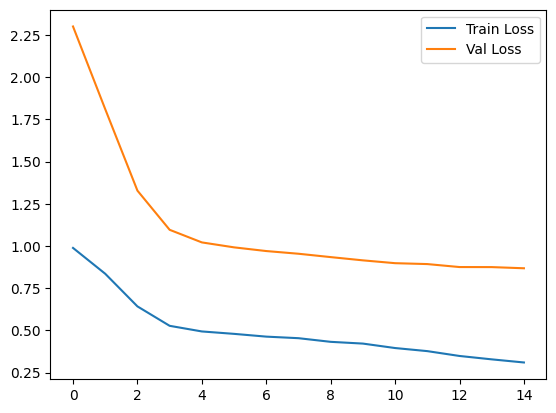

In [57]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(vall_losses, label = 'Val Loss')
plt.legend()
plt.show()

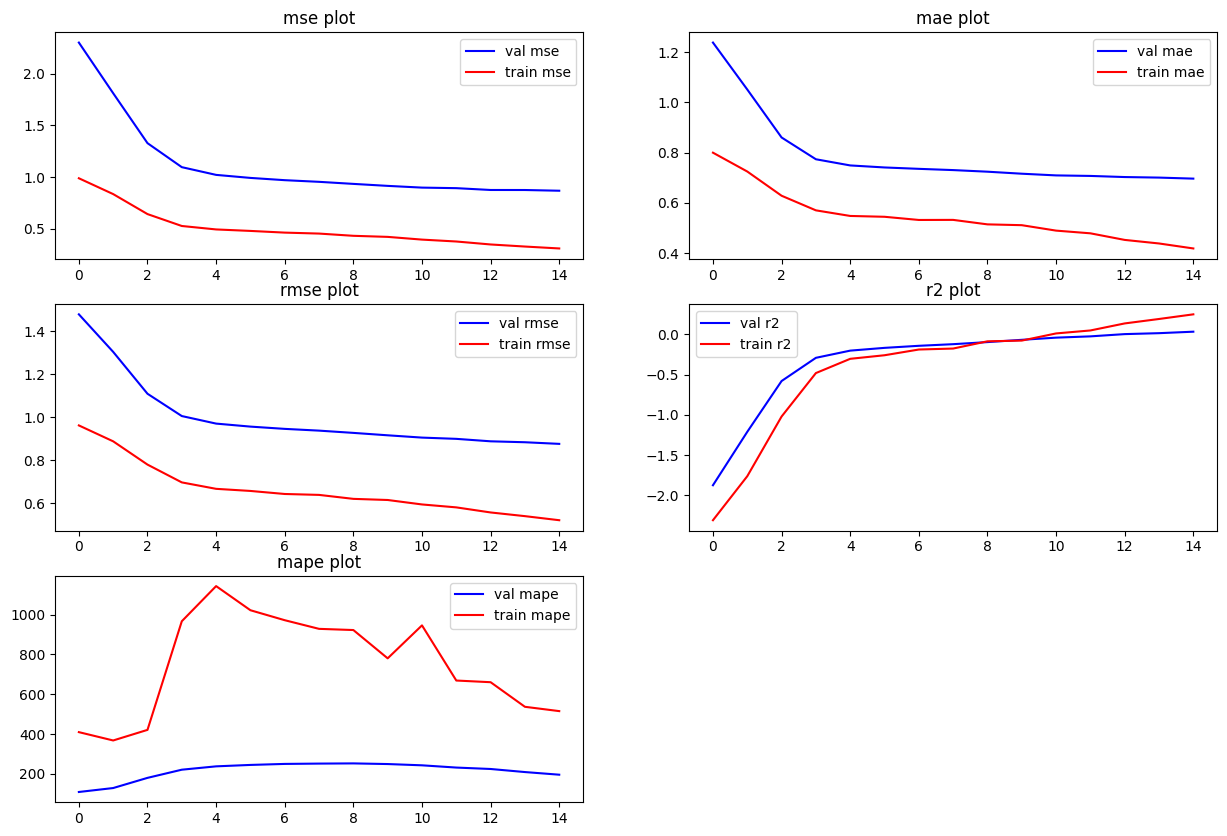

In [58]:
plt.figure(figsize=(15, 10))
for i, k in enumerate(val_metrics.keys()):
    plt.subplot(3, 2, i + 1)
    plt.plot(val_metrics[k], label = f'val {k}', color = 'b')
    plt.plot(train_metrics[k], label = f'train {k}', color = 'r')
    plt.title(f'{k} plot')
    plt.legend()

plt.show()

In [59]:
truth = []
predictions = []
model.eval()
with torch.no_grad():
    val_loss = 0
    for batch_x, batch_y in test_loader:
        predictions.extend(model(batch_x).squeeze().squeeze().cpu().numpy())
        truth.extend(batch_y.squeeze().cpu().numpy())
        break

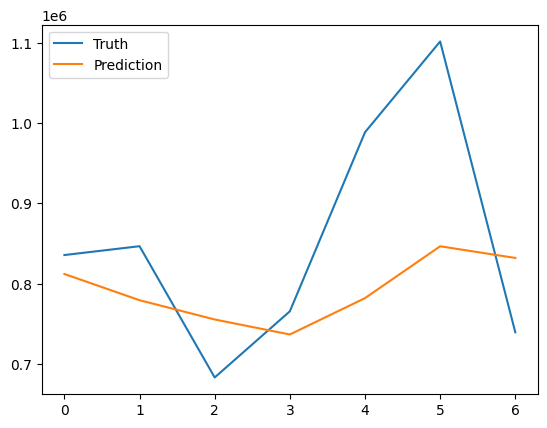

In [60]:
truthx = target_scaler.inverse_transform(torch.tensor(truth[5]).reshape(-1, 1))
predictionsx = target_scaler.inverse_transform(torch.tensor(predictions[5]).reshape(-1, 1))

plt.plot(truthx, label = 'Truth')
plt.plot(predictionsx, label = 'Prediction')
plt.legend()
plt.show()